# OCSVM Baseline Model
*Created by Holger Buech, Q1/2019*

**Description**   

Reimplemenation of a OCSVM approach to Continuous Authentication described by [1]. Used as baseline model for futher experiments.

**Purpose**

- Get basic idea about authentication performance using raw data
- Verify results of [1]

**Data Sources**   

- [H-MOG Dataset](http://www.cs.wm.edu/~qyang/hmog.html)  
  (Downloaded beforehand using  [./src/data/make_dataset.py](./src/data/make_dataset.py), stored in [./data/external/hmog_dataset/](./data/external/hmog_dataset/) and converted to [./data/processed/hmog_dataset.hdf5](./data/processed/hmog_dataset.hdf5))

**References**   

[1] Centeno, M. P. et al. (2018): Mobile Based Continuous Authentication Using Deep Features. Proceedings of the 2^nd International Workshop on Embedded and Mobile Deep Learning (EMDL), 2018, 19-24.

**Table of Contents**

**1 - [Preparations](#1)**  
1.1 - [Imports](#1.1)  
1.2 - [Configuration](#1.2)  
1.3 - [Experiment Parameters](#1.3)  
1.4 - [Select Approach](#1.4)  

**2 - [Data Preparations](#2)**  
2.1 - [Load Dataset](#2.1)  
2.2 - [Normalize Features (if global)](#2.2)  
2.3 - [Split Dataset for Valid/Test](#2.3)  
2.4 - [Check Splits](#2.4)  
2.5 - [Reshape Features](#2.5)  

**3 - [Hyperparameter Optimization](#3)**  
3.1 - [Load cached Data](#3.1)   
3.2 - [Search for Parameters](#3.2)   
3.3 - [Inspect Search Results](#3.3)  

**4 - [Testing](#4)**   
4.1 - [Load cached Data](#4.1)    
4.2 - [Evaluate Authentication Performance](#4.2)  
4.3 - [Evaluate increasing Training Set Size (Training Delay)](#4.3)  
4.4 - [Evaluate increasing Test Set Size (Detection Delay)](#4.4)  

## 1. Preparations <a id='1'>&nbsp;</a> 

### 1.1 Imports <a id='1.1'>&nbsp;</a> 

In [1]:
# Standard
from pathlib import Path
import os
import sys
import dataclasses
import math
import warnings

# Extra
import pandas as pd
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.model_selection import cross_validate, RandomizedSearchCV
import statsmodels.stats.api as sms
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Custom `DatasetLoader`class for easier loading and subsetting data from the datasets.
module_path = os.path.abspath(os.path.join(".."))  # supposed to be parent folder
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utility.dataset_loader_hdf5 import DatasetLoader

# Global utitlity functions are in separate notebook
%run utils.ipynb

### 1.2 Configuration <a id='1.2'>&nbsp;</a>

In [2]:
# Various Settings
SEED = 712  # Used for every random function
HMOG_HDF5 = Path.cwd().parent / "data" / "processed" / "hmog_dataset.hdf5"
EXCLUDE_COLS = ["sys_time"]
CORES = -1

# For plots and CSVs
OUTPUT_PATH = Path.cwd() / "output" / "chapter-6-1-3-ocsvm"
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
REPORT_PATH = Path.cwd().parent / "reports" / "figures" # Figures for thesis

# Plotting
%matplotlib inline
utils_set_output_style()

In [3]:
# Workaround to remove ugly spacing between progress bars
HTML("<style>.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty{padding: 0;border: 0;} div.output_subarea{padding:0;}</style>")

### 1.3 Experiment Parameters <a id='1.3'>&nbsp;</a> 
Selection of parameters set that had been tested in this notebook. Select one of them to reproduce results.

In [4]:
@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Parameter set. Used as identifier for charts etc.
    frequency: int
    max_subjects: int
    max_test_subjects: int
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    task_types: list  # Limit scenarios to [1, 3, 5] for sitting or [2, 4, 6] for walking, or don't limit (None)
    window_size: int  # After resampling
    step_width: int  # After resampling
    scaler: str  # {"std", "robust", "minmax"}
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # fit transform scale on all data (True) or fit on training only (False)
    ocsvm_nu: float  # Best value found in random search, used for final model
    ocsvm_gamma: float  # Best value found in random search, used for final model
    feature_cols: list  # Columns used as features
    exclude_subjects: list  # Don't load data from those users
        
    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        # Number of samples per _session_ used for training:
        self.samples_per_subject_train = math.ceil(
            (self.seconds_per_subject_train * 100)
            / (100 / self.frequency)
            / self.window_size
        )

        # Number of samples per _session_ used for testing:
        self.samples_per_subject_test = math.ceil(
            (self.seconds_per_subject_test * 100)
            / (100 / self.frequency)
            / self.window_size
        )

        

# INSTANCES
# ===========================================================

# NAIVE_APPROACH
# -----------------------------------------------------------
NAIVE_MINMAX_OCSVM = ExperimentParameters(
    name="NAIVE-MINMAX_OCSVM",
    frequency=100,
    max_subjects=90,
    max_test_subjects=30,
    seconds_per_subject_train=67.5,
    seconds_per_subject_test=67.5,    
    task_types=None,
    window_size=50,
    step_width=50,
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    ocsvm_nu=0.086,
    ocsvm_gamma=0.091,
    feature_cols=[
        "acc_x",
        "acc_y",
        "acc_z",
        "gyr_x",
        "gyr_y",
        "gyr_z",
        "mag_x",
        "mag_y",
        "mag_z",
    ],
    exclude_subjects=[
        "733162",  # No 24 sessions
        "526319",  # ^
        "796581",  # ^
        "539502",  # Least amount of sensor values
        "219303",  # ^
        "737973",  # ^
        "986737",  # ^
        "256487",  # Most amount of sensor values
        "389015",  # ^
        "856401",  # ^
    ],
)

# VALID_APPROACH
# -----------------------------------------------------------
VALID_MINMAX_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-MINMAX-OCSVM",
    scaler_global=False,
    ocsvm_nu=0.165,
    ocsvm_gamma=0.039,
)

# NAIVE_ROBUST_APPROACH
# -----------------------------------------------------------
NAIVE_ROBUST_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="NAIVE-ROBUST-OCSVM",
    scaler="robust",
    scaler_global=True,
    ocsvm_nu=0.153,
    ocsvm_gamma=0.091,  # below median, selected by chart
)

# ROBUST_APPROACH (VALID)
# -----------------------------------------------------------
VALID_ROBUST_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="robust",
    scaler_global=False,
    ocsvm_nu=0.098,
    ocsvm_gamma=0.003,
)

### 1.4 Select approach <a id='1.4'>&nbsp;</a> 
Select the parameters to use for current notebook execution here!

In [5]:
P = VALID_ROBUST_OCSVM

**Overview of current Experiment Parameters:**

In [6]:
utils_ppp(P)

,Value
exclude_subjects,"[733162, 526319, 796581, 539502, 219303, 73797..."
feature_cols,"[acc_x, acc_y, acc_z, gyr_x, gyr_y, gyr_z, mag..."
frequency,100
max_subjects,90
max_test_subjects,30
name,VALID-ROBUST-OCSVM
ocsvm_gamma,0.003
ocsvm_nu,0.098
scaler,robust
scaler_global,False


## 2. Data Preparation <a id='2'>&nbsp;</a> 

### 2.1 Load Dataset <a id='2.1'>&nbsp;</a> 

In [7]:
hmog = DatasetLoader(
    hdf5_file=HMOG_HDF5,
    table_name=P.table_name,
    max_subjects=P.max_subjects,
    task_types=P.task_types,
    exclude_subjects=P.exclude_subjects,
    exclude_cols=EXCLUDE_COLS,
    seed=SEED,
)

hmog.data_summary()

,DataFrame,Memory (MB),Rows,Columns,Subjects,Sessions
0,all,11155.52,112475144,12,90,2160
1,index,0.08,2160,4,90,2160


### 2.2 Normalize features (if global) <a id='2.2'>&nbsp;</a> 
Used here for naive approach (before splitting into test and training sets). Otherwise it's used during generate_pairs() and respects train vs. test borders.

In [8]:
if P.scaler_global:
    print("Normalize all data before splitting into train and test sets...")
    hmog.all, _ = utils_custom_scale(
        hmog.all,
        scale_cols=P.feature_cols,        
        feature_cols=P.feature_cols,
        scaler_name=P.scaler,
        scope=P.scaler_scope,
        plot=True,
    )
else:
    print("Skipped, normalize after splitting.")

Skipped, normalize after splitting.


### 2.3 Split Dataset for Valid/Test <a id='2.3'>&nbsp;</a> 
In two splits: one used during hyperparameter optimization, and one used during testing.

The split is done along the subjects: All sessions of a single subject will either be in the validation split or in the testing split, never in both.

In [9]:
hmog.split_train_test(n_test_subjects=P.max_test_subjects)
hmog.data_summary()

,DataFrame,Memory (MB),Rows,Columns,Subjects,Sessions
0,index,0.08,2160,4,90,2160
1,train,7539.22,76013863,12,60,1440
2,test,3616.31,36461281,12,30,720


### 2.4 Check Splits <a id='2.4'>&nbsp;</a> 

In [10]:
utils_split_report(hmog.train)

Unique subjects: 60
Unique sessions: 1440

Head:


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,subject,session,task_type
0,0.240019,7.783550,5.087678,0.023729,-0.087669,-0.298940,-17.868000,15.582000,-30.400000,100669,100669_session_1,0
1,0.230074,7.788090,5.080470,0.024885,-0.085446,-0.296594,-17.855675,15.556771,-30.374313,100669,100669_session_1,0
2,0.220130,7.792631,5.073262,0.026041,-0.083223,-0.294248,-17.843349,15.531542,-30.348626,100669,100669_session_1,0
3,0.210185,7.797171,5.066054,0.027196,-0.080999,-0.291902,-17.831024,15.506313,-30.322939,100669,100669_session_1,0
4,0.200241,7.801712,5.058845,0.028352,-0.078776,-0.289556,-17.818699,15.481084,-30.297253,100669,100669_session_1,0




Sessions' Task Types per subject:


subject,100669,171538,201848,207696,220962,240168,257279,261313,277905,278135,326223,342329,352716,366286,368258,395129,396697,398248,431312,472761,489146,525584,527796,538363,540641,554303,556357,578526,588087,594887,621276,622852,657486,693572,698266,710707,733568,745224,763813,776328,777078,785899,815316,827212,856302,863985,865501,872895,876011,879155,892687,893255,897652,918136,923862,966655,973891,980953,984799,990622
1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
5,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
6,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


In [11]:
utils_split_report(hmog.test)

Unique subjects: 30
Unique sessions: 720

Head:


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,subject,session,task_type
0,-1.277905,5.390545,7.082647,-0.058948,-0.057727,-0.014966,-33.239,24.833,-51.906,151985,151985_session_1,1
1,-1.329381,5.562329,6.672640,-0.093004,-0.048258,0.026878,-33.082,24.833,-51.750,151985,151985_session_1,1
2,-1.330150,5.550244,6.693333,-0.127060,-0.038790,0.068722,-33.082,24.833,-51.750,151985,151985_session_1,1
3,-1.330920,5.538159,6.714026,-0.177151,-0.095906,0.057421,-33.082,24.833,-51.750,151985,151985_session_1,1
4,-1.331689,5.526074,6.734719,-0.231212,-0.123089,0.047647,-33.082,24.833,-51.750,151985,151985_session_1,1




Sessions' Task Types per subject:


subject,151985,180679,186676,218719,248252,264325,336172,405035,501973,553321,561993,579284,663153,675397,717868,720193,751131,771782,785873,799296,803262,808022,841866,862649,865881,893198,913228,937904,962159,998757
1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
5,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
6,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


### 2.5 Reshape Features  <a id='2.5'>&nbsp;</a> 

**Reshape & store Set for Validation:**

In [12]:
df_train_valid = utils_reshape_features(
    hmog.train,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

# Clean memory
del hmog.train
%reset_selective -f hmog.train

print("Validation data after reshaping:")
display(df_train_valid.head())

# Store iterim data
df_train_valid.to_msgpack(OUTPUT_PATH / "df_train_valid.msg")

# Clean memory
%reset_selective -f df_train_valid

Validation data after reshaping:


,X,subject,session,task_type
0,"[[0.24001873, 7.78355, 5.087678400000001, 0.02...",100669,100669_session_1,1
1,"[[-0.2572057427367999, 8.010571461781408, 4.72...",100669,100669_session_1,1
2,"[[-1.0044076797661055, 7.842985830469546, 5.94...",100669,100669_session_1,1
3,"[[-0.49164919223389436, 8.049485102863787, 5.3...",100669,100669_session_1,1
4,"[[0.3088059028501099, 7.771210358321584, 5.544...",100669,100669_session_1,1


**Reshape & store Set for Testing:**

In [13]:
df_train_test = utils_reshape_features(
    hmog.test,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

del hmog.test
%reset_selective -f hmog.test

print("Testing data after reshaping:")
display(df_train_test.head())

# Store iterim data
df_train_test.to_msgpack(OUTPUT_PATH / "df_train_test.msg")

# Clean memory
%reset_selective -f df_train_test

Testing data after reshaping:


,X,subject,session,task_type
0,"[[-1.2779051000000001, 5.3905449999999995, 7.0...",151985,151985_session_1,1
1,"[[-1.325744888888889, 5.459932562962963, 6.933...",151985,151985_session_1,1
2,"[[-1.340698520553518, 5.9301654312142755, 6.83...",151985,151985_session_1,1
3,"[[-1.6763305356696576, 6.273255463583686, 6.64...",151985,151985_session_1,1
4,"[[-1.8191173046777376, 6.427219945158932, 6.40...",151985,151985_session_1,1


In [14]:
# Clean Memory
%reset_selective -f df_

## 3. Hyperparameter Optimization  <a id='3'>&nbsp;</a> 

### 3.1 Load cached Data <a id='3.1'>&nbsp;</a> 
Only the split dedicated for hyperparameter optimization is loaded

In [15]:
df_train_valid = pd.read_msgpack(OUTPUT_PATH / "df_train_valid.msg")
df_train_valid.head()

,X,subject,session,task_type
0,"((0.24001873, 7.78355, 5.087678400000001, 0.02...",100669,100669_session_1,1
1,"((-0.2572057427367999, 8.010571461781408, 4.72...",100669,100669_session_1,1
2,"((-1.0044076797661055, 7.842985830469546, 5.94...",100669,100669_session_1,1
3,"((-0.49164919223389436, 8.049485102863787, 5.3...",100669,100669_session_1,1
4,"((0.3088059028501099, 7.771210358321584, 5.544...",100669,100669_session_1,1


### 3.2 Search for Parameters <a id='3.2'>&nbsp;</a> 

In [16]:
param_dist = {"gamma": np.logspace(-3, 3), "nu": np.linspace(0.0001, 0.3)}
warnings.filterwarnings("ignore")
df_results = None  # Will be filled with randomsearch scores
for run in tqdm(range(3)):
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_train_valid,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            seed=SEED + run,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_train_valid["subject"].nunique(),
        leave=False,
    ):
        X = np.array(df_cv_scenarios["X"].values.tolist())
        X = X.reshape(X.shape[-3], -1)  # flatten windows
        y = df_cv_scenarios["label"].values
        train_valid_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)
        model = OneClassSVM(kernel="rbf")

        random_search = RandomizedSearchCV(
            model,
            param_distributions=param_dist,
            cv=train_valid_cv,
            n_iter=80,
            n_jobs=CORES,
            refit=False,
            scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            verbose=0,
            return_train_score=False,
            iid=False,
            random_state=SEED,
        )
        random_search.fit(X, y)
        df_report = utils_cv_report(random_search, owner, impostors)
        df_report["run"] = run
        df_results = pd.concat([df_results, df_report], sort=False)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_random_search_results.csv", index=False)

### 3.3 Inspect Search Results <a id='3.3'>&nbsp;</a> 
**Raw Results & Stats:**

In [17]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_random_search_results.csv")
print("Example from result table (head):")
display(
    df_results[df_results["rank_test_eer"] == 1]
    .sort_values("mean_test_eer")
    .head(10)
)
print("\n\n\nMost relevant statistics:")
display(
    df_results[df_results["rank_test_eer"] == 1][
        [
            "mean_fit_time",
            "param_nu",
            "param_gamma",
            "mean_test_accuracy",
            "std_test_accuracy",
            "mean_test_eer",
            "std_test_eer",
        ]
    ].describe()
)

Example from result table (head):


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_nu,param_gamma,777078_test_eer,763813_test_eer,693572_test_eer,220962_test_eer,278135_test_eer,261313_test_eer,892687_test_eer,879155_test_eer,395129_test_eer,525584_test_eer,865501_test_eer,966655_test_eer,396697_test_eer,326223_test_eer,342329_test_eer,657486_test_eer,872895_test_eer,876011_test_eer,366286_test_eer,984799_test_eer,489146_test_eer,973891_test_eer,918136_test_eer,540641_test_eer,556357_test_eer,257279_test_eer,201848_test_eer,745224_test_eer,827212_test_eer,863985_test_eer,698266_test_eer,472761_test_eer,621276_test_eer,368258_test_eer,538363_test_eer,893255_test_eer,554303_test_eer,171538_test_eer,594887_test_eer,527796_test_eer,277905_test_eer,100669_test_eer,815316_test_eer,897652_test_eer,710707_test_eer,398248_test_eer,923862_test_eer,588087_test_eer,990622_test_eer,785899_test_eer,207696_test_eer,352716_test_eer,578526_test_eer,856302_test_eer,240168_test_eer,980953_test_eer,622852_test_eer,776328_test_eer,431312_test_eer,mean_test_eer,std_test_eer,rank_test_eer,777078_test_accuracy,763813_test_accuracy,693572_test_accuracy,220962_test_accuracy,278135_test_accuracy,261313_test_accuracy,892687_test_accuracy,879155_test_accuracy,395129_test_accuracy,525584_test_accuracy,865501_test_accuracy,966655_test_accuracy,396697_test_accuracy,326223_test_accuracy,342329_test_accuracy,657486_test_accuracy,872895_test_accuracy,876011_test_accuracy,366286_test_accuracy,984799_test_accuracy,489146_test_accuracy,973891_test_accuracy,918136_test_accuracy,540641_test_accuracy,556357_test_accuracy,257279_test_accuracy,201848_test_accuracy,745224_test_accuracy,827212_test_accuracy,863985_test_accuracy,698266_test_accuracy,472761_test_accuracy,621276_test_accuracy,368258_test_accuracy,538363_test_accuracy,893255_test_accuracy,554303_test_accuracy,171538_test_accuracy,594887_test_accuracy,527796_test_accuracy,277905_test_accuracy,100669_test_accuracy,815316_test_accuracy,897652_test_accuracy,710707_test_accuracy,398248_test_accuracy,923862_test_accuracy,588087_test_accuracy,990622_test_accuracy,785899_test_accuracy,207696_test_accuracy,352716_test_accuracy,578526_test_accuracy,856302_test_accuracy,240168_test_accuracy,980953_test_accuracy,622852_test_accuracy,776328_test_accuracy,431312_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,owner,run,733568_test_eer,733568_test_accuracy
402,0.009761,0.004564,0.012164,0.005816,0.110267,0.004095,0.245283,0.245283,0.148148,0.163265,NaN,0.156863,0.365079,0.166667,0.166667,0.230769,0.150943,0.259259,0.145455,0.310345,0.150943,0.145455,0.156863,0.156863,0.150943,0.183673,0.142857,0.230769,0.142857,0.183673,0.142857,0.156863,0.142857,0.142857,0.142857,0.160000,0.142857,0.153846,0.150943,0.150943,0.150943,0.160000,0.259259,0.153846,0.200000,0.310345,0.142857,0.166667,0.145455,0.148148,0.166667,0.259259,0.156863,0.163265,0.245283,0.150943,0.285714,0.153846,0.183673,0.145455,0.163265,0.142857,0.150943,0.150943,0.163265,0.180760,0.051595,1.0,0.781250,0.781250,0.895833,0.843750,NaN,0.864583,0.677083,0.833333,0.833333,0.791667,0.885417,0.770833,0.906250,0.729167,0.885417,0.906250,0.864583,0.864583,0.885417,0.822917,0.916667,0.791667,0.916667,0.822917,0.916667,0.864583,0.916667,0.916667,0.916667,0.854167,0.916667,0.875000,0.885417,0.885417,0.885417,0.854167,0.770833,0.875000,0.812500,0.729167,0.916667,0.833333,0.906250,0.895833,0.833333,0.770833,0.864583,0.843750,0.781250,0.885417,0.750000,0.875000,0.822917,0.906250,0.843750,0.916667,0.885417,0.885417,0.843750,0.850459,0.056918,2,278135,0,0.259259,0.770833
4449,0.005101,0.000812,0.004923,0.000613,0.091906,0.001000,0.322034,0.156863,0.142857,0.145455,0.344262,0.150943,0.200000,0.153846,0.142857,0.230769,0.142857,0.322034,0.150943,0.160000,0.230769,0.142857,0.142857,0.160000,0.215686,0.200000,0.142857,0.333333,0.272727,0.230769,0.156863,0.230769,0.145455,0.145455,0.160000,0.322034,0.142857,0.150943,0.322034,0.156863,0.145455,0.142857,0.183673,0.148148,0.163265,0.14




Most relevant statistics:


,mean_fit_time,param_nu,param_gamma,mean_test_accuracy,std_test_accuracy,mean_test_eer,std_test_eer
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.006901,0.116667,0.003089,0.666988,0.091926,0.357143,0.076683
std,0.002587,0.072824,0.005182,0.079878,0.018920,0.072097,0.021399
min,0.003620,0.024582,0.001000,0.506179,0.005378,0.180760,0.002807
25%,0.005130,0.073545,0.001326,0.605579,0.083649,0.301700,0.065363
50%,0.006352,0.091906,0.002330,0.654308,0.093903,0.363971,0.080972
75%,0.007769,0.159231,0.003089,0.728549,0.105206,0.410468,0.089965
max,0.015278,0.287759,0.068665,0.850459,0.122912,0.489730,0.123373


**Plot parameters of top n of 30 results for every Owner:**

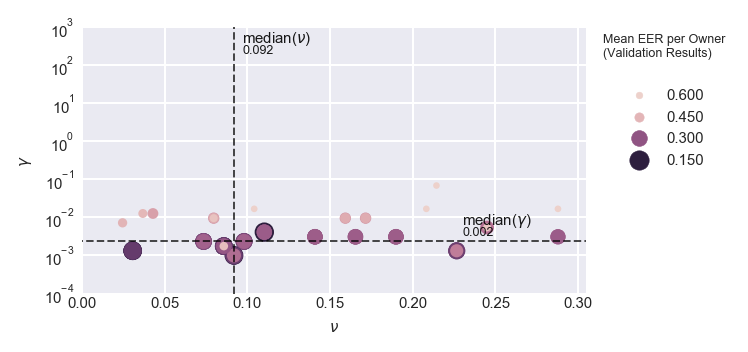

In [18]:
utils_plot_randomsearch_results(df_results, n_top=1)
utils_save_plot(plt, REPORT_PATH / f"buech2019-ocsvm-{P.name.lower()}-parameters.pdf")

**Note:** Using median to select the best parameters, as mean is strongly influenced by outliers.

In [19]:
# Clean Memory
%reset_selective -f df_

## 4. Testing <a id='4'>&nbsp;</a> 

### 4.1 Load cached Data <a id='4.1'>&nbsp;</a> 
During testing, a split with different users than used for hyperparameter optimization is used:

In [20]:
df_train_test = pd.read_msgpack(OUTPUT_PATH / "df_train_test.msg")

### 4.2 Evaluate Authentication Performance <a id='4.2'>&nbsp;</a> 

- Using Testing Split, Scenario Cross Validation, and multiple runs to lower impact of random session/sample selection.

In [21]:
df_results = None  # Will be filled with cv scores

for i in tqdm(range(5), desc="Run", leave=False):  # Run whole test 5 times
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_train_test,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            seed=SEED + i,  # Change seed for different runs
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_train_test["subject"].nunique(),
        leave=False,
    ):
        X = np.array(df_cv_scenarios["X"].values.tolist())
        X = X.reshape(X.shape[-3], -1)  # flatten windows
        y = df_cv_scenarios["label"].values
        train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = OneClassSVM(kernel="rbf", nu=P.ocsvm_nu, gamma=P.ocsvm_gamma)

        scores = cross_validate(
            model,
            X,
            y,
            cv=train_test_cv,
            scoring={
                "eer": utils_eer_scorer,
                "accuracy": "accuracy",
                "precision": "precision",
                "recall": "recall",
            },
            n_jobs=CORES,
            verbose=0,
            return_train_score=True,
        )
        df_score = pd.DataFrame(scores)
        df_score["owner"] = owner
        df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
        df_score["test_eer"] = df_score["test_eer"].abs()
        df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_test_results.csv", index=False)

df_results.head()

,fit_time,score_time,test_eer,train_eer,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,owner
0,0.006488,0.016469,0.480769,1.818989e-12,0.520833,0.819444,0.519231,1.0,0.5625,0.819444,808022
1,0.006489,0.017967,0.500000,1.818989e-12,0.500000,0.819444,0.500000,1.0,0.5625,0.819444,808022
2,0.006487,0.016969,0.480769,1.818989e-12,0.520833,0.819444,0.519231,1.0,0.5625,0.819444,808022
3,0.008485,0.023954,0.534483,1.818989e-12,0.458333,0.819444,0.465517,1.0,0.5625,0.819444,808022
4,0.008982,0.018466,0.571429,1.818989e-12,0.406250,0.819444,0.428571,1.0,0.5625,0.819444,808022


**Load Results from "EER & Accuracy" evaluation & prepare for plotting:**

In [22]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_test_results.csv")
df_plot = df_results.rename(
    columns={"test_accuracy": "Test Accuracy", "test_eer": "Test EER", "owner": "Owner"}
).astype({"Owner": str})

**Plot Distribution of Accuracy per subject:**

Overall mean: 0.6175


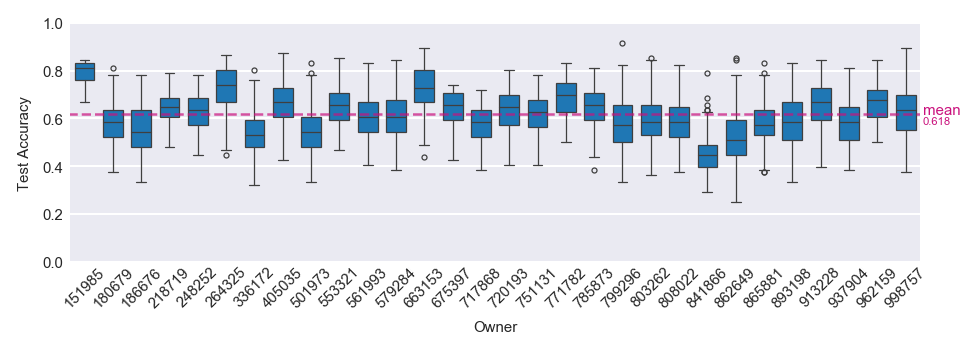

In [23]:
fig = utils_plot_acc_eer_dist(df_plot, "Test Accuracy")
utils_save_plot(plt, REPORT_PATH / f"buech2019-ocsvm-{P.name.lower()}-acc.pdf")

Overall mean: 0.4077


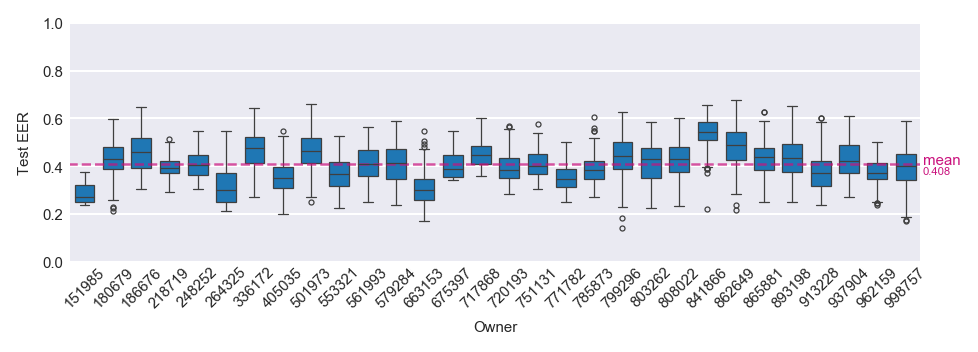

In [24]:
fig = utils_plot_acc_eer_dist(df_plot, "Test EER")
utils_save_plot(plt, REPORT_PATH / f"buech2019-ocsvm-{P.name.lower()}-eer.pdf")

### 4.3 Evaluate increasing Training Set Size (Training Delay)<a id='4.3'>&nbsp;</a> 

- Testing different amounts of samples in training set
- Using Testing Split, Scenario Cross Validation, and multiple runs to lower impact of random session/sample selection.

In [25]:
training_set_sizes = [2, 4, 6, 8, 20, 60, 120, 180, 250, 350, 500, 750]

df_results = None  # Will be filled with cv scores
for i in tqdm(range(5), desc="Run", leave=False):
    for n_train_samples in tqdm(training_set_sizes, desc="Train Size", leave=False):
        for df_cv_scenarios, owner, impostors in tqdm(
            utils_generate_cv_scenarios(
                df_train_test,
                samples_per_subject_train=P.samples_per_subject_train,
                samples_per_subject_test=P.samples_per_subject_test,
                limit_train_samples=n_train_samples,  # samples overall
                seed=SEED + i,  # Change seed for different runs
                scaler=P.scaler,
                scaler_global=P.scaler_global,
                scaler_scope=P.scaler_scope,
                feature_cols=P.feature_cols,
            ),
            desc="Owner",
            total=df_train_test["subject"].nunique(),
            leave=False,
        ):
            X = np.array(df_cv_scenarios["X"].values.tolist())
            X = X.reshape(X.shape[-3], -1)  # flatten windows
            y = df_cv_scenarios["label"].values
            train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

            model = OneClassSVM(kernel="rbf", nu=P.ocsvm_nu, gamma=P.ocsvm_gamma)

            scores = cross_validate(
                model,
                X,
                y,
                cv=train_test_cv,
                scoring={"eer": utils_eer_scorer},
                n_jobs=CORES,
                verbose=0,
                return_train_score=True,
            )
            df_score = pd.DataFrame(scores)
            df_score["owner"] = owner
            df_score["train_samples"] = n_train_samples
            df_score["train_eer"] = df_score[
                "train_eer"
            ].abs()  # Revert scorer's signflip
            df_score["test_eer"] = df_score["test_eer"].abs()
            df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_train_delay_results.csv", index=False)
df_results.head()

,fit_time,score_time,test_eer,train_eer,owner,train_samples
0,0.000998,0.000499,0.5,1.818989e-12,808022,2
1,0.000499,0.000998,0.5,1.818989e-12,808022,2
2,0.000499,0.000998,0.5,1.818989e-12,808022,2
3,0.001496,0.000997,0.5,1.818989e-12,808022,2
4,0.001497,0.001497,0.5,1.818989e-12,808022,2


**Load Results from "Training set size" evaluation & prepare for plotting:**

In [26]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_train_delay_results.csv")
df_plot = (
    df_results[["test_eer", "owner", "train_samples"]]
    .groupby(["owner", "train_samples"], as_index=False)
    .mean()
    .astype({"owner": "category"})
    .rename(
        columns={
            "test_eer": "Test EER",
            "owner": "Owner",
        }
    )
)
df_plot["Training Data in Seconds"] = df_plot["train_samples"] * P.window_size / P.frequency

**Plot EER with increasing number of training samples:**

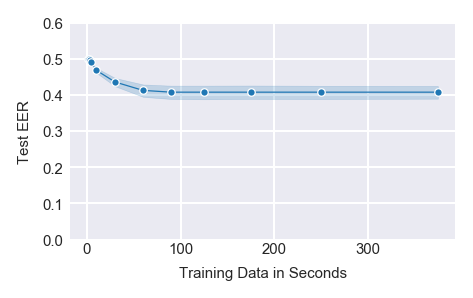

In [27]:
utils_plot_training_delay(df_plot)
utils_save_plot(plt, REPORT_PATH / f"buech2019-ocsvm-{P.name.lower()}-train-size.pdf")

### 4.4 Evaluate increasing Test Set Sizes (Detection Delay)<a id='4.4'>&nbsp;</a> 

In [28]:
df_results = None  # Will be filled with cv scores
for i in tqdm(range(20), desc="Run", leave=False):
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_train_test,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            limit_test_samples=1,  # Samples overall
            seed=SEED + i,  # Change seed for different runs
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_train_test["subject"].nunique(),
        leave=False,
    ):
        X = np.array(df_cv_scenarios["X"].values.tolist())
        X = X.reshape(X.shape[-3], -1)  # flatten windows
        y = df_cv_scenarios["label"].values
        train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = OneClassSVM(kernel="rbf", nu=P.ocsvm_nu, gamma=P.ocsvm_gamma)

        scores = cross_validate(
            model,
            X,
            y,
            cv=train_test_cv,
            scoring={"eer": utils_eer_scorer},
            n_jobs=CORES,
            verbose=0,
            return_train_score=True,
        )
        df_score = pd.DataFrame(scores)
        df_score["owner"] = owner
        df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
        df_score["test_eer"] = df_score["test_eer"].abs()
        df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_detect_delay_results.csv", index=False)
df_results.head()

,fit_time,score_time,test_eer,train_eer,owner
0,0.004990,0.000499,0.0,1.818989e-12,808022
1,0.004990,0.000499,0.0,1.818989e-12,808022
2,0.004988,0.000500,0.0,1.818989e-12,808022
3,0.005490,0.000999,0.0,1.818989e-12,808022
4,0.005490,0.000996,0.5,1.818989e-12,808022


**Load Results from "Detection Delay" evaluation & prepare for plotting:**

In [29]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_detect_delay_results.csv")
df_results["owner"] = df_results["owner"].astype(str)
df_plot = df_results.copy()

**Plot Expanding Mean EER and confidence interval:**

Mean samples: 47.5
Mean seconds: 23.8


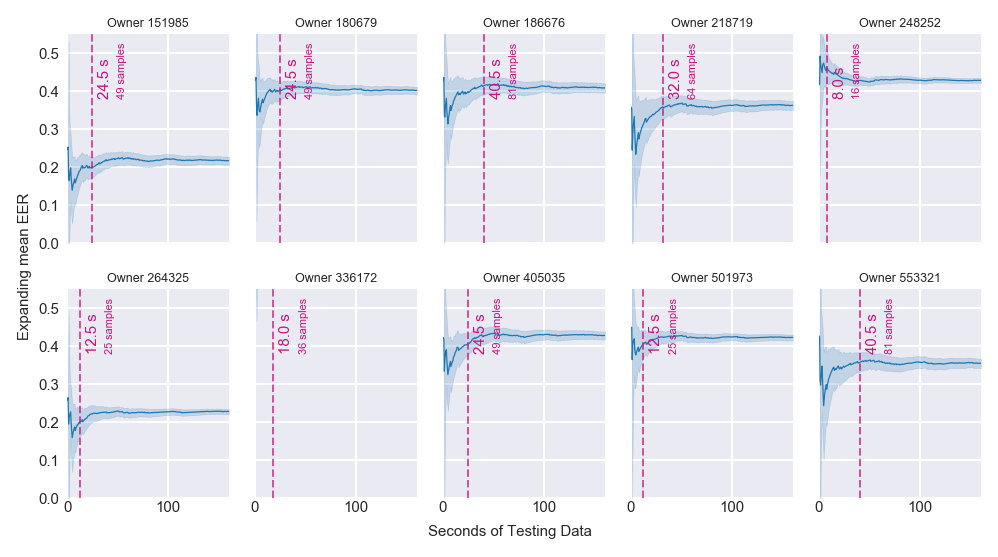

In [30]:
utils_plot_detect_delay(df_plot, factor=P.window_size / P.frequency, xlim=160)
utils_save_plot(plt, REPORT_PATH / f"buech2019-ocsvm-{P.name.lower()}-detection-delay.pdf")